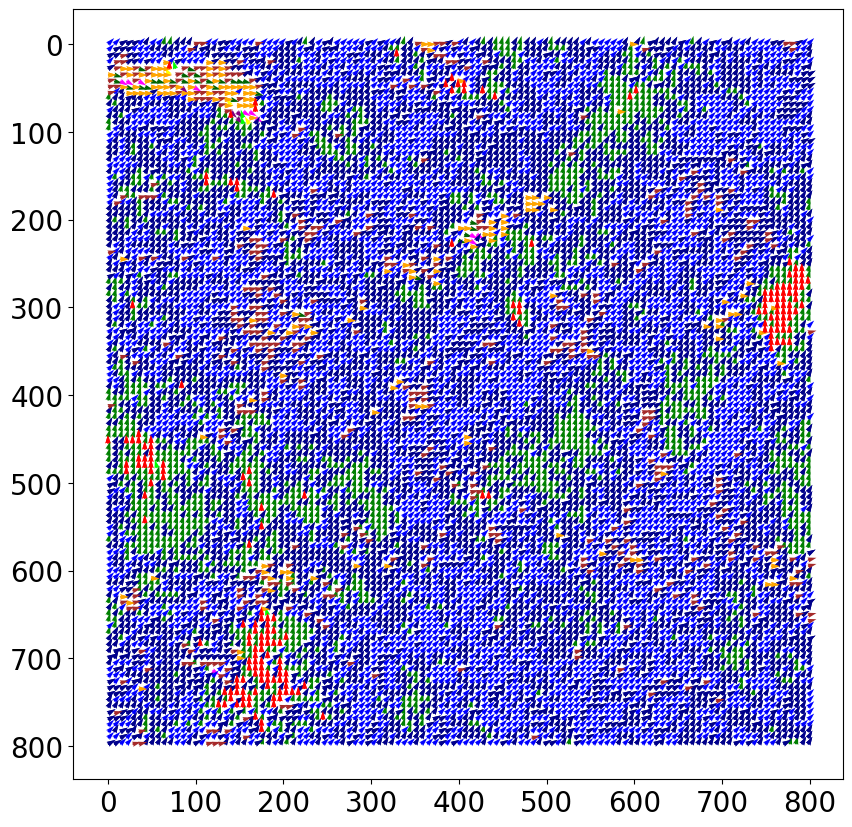

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from collections import defaultdict
import math

# List of perpendicular-angle image pairs
angles_regular = [(-90, 0), (-75, 15), (-60, 30), (-45, 45), (-30, 60), (-15, 75), (0, 90)]
image_pairs = [(f'{abs(angle1)}_aligned.png' if angle1 > 0 else f'{angle1}_aligned.png',
                f'{abs(angle2)}_aligned.png' if angle2 > 0 else f'{angle2}_aligned.png') 
               for angle1, angle2 in angles_regular]

# Load the first image to get dimensions
sample_image = cv2.imread(image_pairs[0][0])
if sample_image is None:
    raise FileNotFoundError(f"Sample image {image_pairs[0][0]} not found.")

# Define the 800x800 region of interest (ROI)
roi_size = 800
height, width, _ = sample_image.shape
start_x = (width - roi_size) // 2  # Center the ROI horizontally
start_y = (height - roi_size) // 2  # Center the ROI vertically

# Ensure ROI fits within the image
if start_x < 0 or start_y < 0 or start_x + roi_size > width or start_y + roi_size > height:
    raise ValueError("The ROI size is larger than the image dimensions.")

# Array storing BOI values for each pixel at each angle inside the ROI
BOI_values = np.zeros((len(angles_regular), roi_size, roi_size))


# Define a threshold for minimum channel difference
diff_threshold = 5  # Adjust this value as needed

# Loop through each pair of images and calculate BOI for each pixel in the ROI
for i, (minus_img, plus_img) in enumerate(image_pairs):
    image_plus = cv2.imread(plus_img)
    image_minus = cv2.imread(minus_img)
    if image_plus is None or image_minus is None:
        print(f"Error loading images: {plus_img} or {minus_img}")
        continue

    # Extract the blue channel from the ROI
    B_plus = cv2.split(image_plus[start_y:start_y + roi_size, start_x:start_x + roi_size])[0]
    B_minus = cv2.split(image_minus[start_y:start_y + roi_size, start_x:start_x + roi_size])[0]

    # Convert to float for calculations and prevent division by zero
    B_plus_float = B_plus.astype(np.float32) + 1
    B_minus_float = B_minus.astype(np.float32) + 1

    # Compute absolute difference
    diff = np.abs(B_minus_float - B_plus_float)

    # Create a mask where the difference is above the threshold
    valid_mask = diff > diff_threshold

    # Compute BOI only for valid pixels, set others to NaN or zero
    BOI_blue = np.zeros_like(B_plus_float, dtype=np.float32)  # Initialize with zeros
    BOI_blue[valid_mask] = (B_minus_float[valid_mask] - B_plus_float[valid_mask]) / (B_minus_float[valid_mask] + B_plus_float[valid_mask])

    # Apply median filter to smooth valid BOI values
    BOI_blue_filtered = median_filter(BOI_blue, size=3)

    # Store the filtered BOI values
    BOI_values[i] = BOI_blue_filtered

# Find the absolute maximum BOI for each pixel and its angle index
max_abs_BOI_indices = np.argmax(np.abs(BOI_values), axis=0)

# Define the mapping for angles and directions
angle_to_vector = {
    (-90, 0): {True: (0, -1), False: (1, 0)},  # -45 and 45 combined
    (-75, 15): {True: (math.cos(math.radians(75)), -math.sin(math.radians(75))), False: (math.cos(math.radians(15)), math.sin(math.radians(15)))},  
    (-60, 30): {True: (math.cos(math.radians(60)), -math.sin(math.radians(60))), False: (math.cos(math.radians(30)), math.sin(math.radians(30)))},  
    (-45, 45): {True: (math.cos(math.radians(45)), -math.sin(math.radians(45))), False: (math.cos(math.radians(45)), math.sin(math.radians(45)))},  
    (-30, 60): {True: (math.cos(math.radians(30)), -math.sin(math.radians(30))), False: (math.cos(math.radians(120)), -math.sin(math.radians(120)))},  
    (-15, 75): {True: (math.cos(math.radians(15)), -math.sin(math.radians(15))), False: (math.cos(math.radians(105)), -math.sin(math.radians(105)))},  
    (0, 90): {True: (1, 0), False: (0, -1)}  
}

colors = {
    ((-90, 0), True): 'red',             
    ((-90, 0), False): 'orange',           
    ((-75, 15), True): 'green',          
    ((-75, 15), False): 'darkgreen',     
    ((-60, 30), True): 'darkblue',           
    ((-60, 30), False): 'magenta',      
    ((-45, 45), True): 'blue',         
    ((-45, 45), False): 'purple',        
    ((-30, 60), True): 'darkblue',        
    ((-30, 60), False): 'yellow',        
    ((-15, 75), True): 'brown',          
    ((-15, 75), False): 'lime',          
    ((0, 90), True): 'orange',              
    ((0, 90), False): 'red'             
}

# Initialize vector components, colors, and histogram dictionary
U = np.zeros((roi_size, roi_size))
V = np.zeros((roi_size, roi_size))
C = np.empty((roi_size, roi_size), dtype=object)  
histogram = defaultdict(int)

# Assign vectors and calculate histogram
for i in range(roi_size):
    for j in range(roi_size):
        max_idx = max_abs_BOI_indices[i, j]
        angle_pair = angles_regular[max_idx]
        original_value = BOI_values[max_idx, i, j]
        is_positive = original_value > 0

        # Increment the histogram count for the corresponding angle and direction
        histogram[(angle_pair, is_positive)] += 1

        # Assign vectors and colors
        if angle_pair in angle_to_vector:
            vector = angle_to_vector[angle_pair][is_positive]
            U[i, j], V[i, j] = vector
            C[i, j] = colors[(angle_pair, is_positive)]

# Uniform scaling for visualization
scaling_factor = 10
U *= scaling_factor
V *= scaling_factor

# Downsample for better visualization
X, Y = np.meshgrid(np.arange(0, roi_size, 7), np.arange(0, roi_size, 7))
U_down = U[::7, ::7]
V_down = V[::7, ::7]
C_down = C[::7, ::7]

# Plot the quiver plot with unique colors for each vector
plt.figure(figsize=(10, 10))
quiver_plots = []
labels = []

for (angle_pair, is_positive), color in colors.items():
    mask = np.array([[C_down[i, j] == color for j in range(C_down.shape[1])] for i in range(C_down.shape[0])])
    q = plt.quiver(X[mask], Y[mask], U_down[mask], V_down[mask], color=color, angles='xy', scale_units='xy', scale=1)
    quiver_plots.append(q)
    labels.append(f"Angle {angle_pair}, {'+' if is_positive else '-'}")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)




plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.savefig('roi_high_res_plot_vector.png', dpi=300)
plt.show()


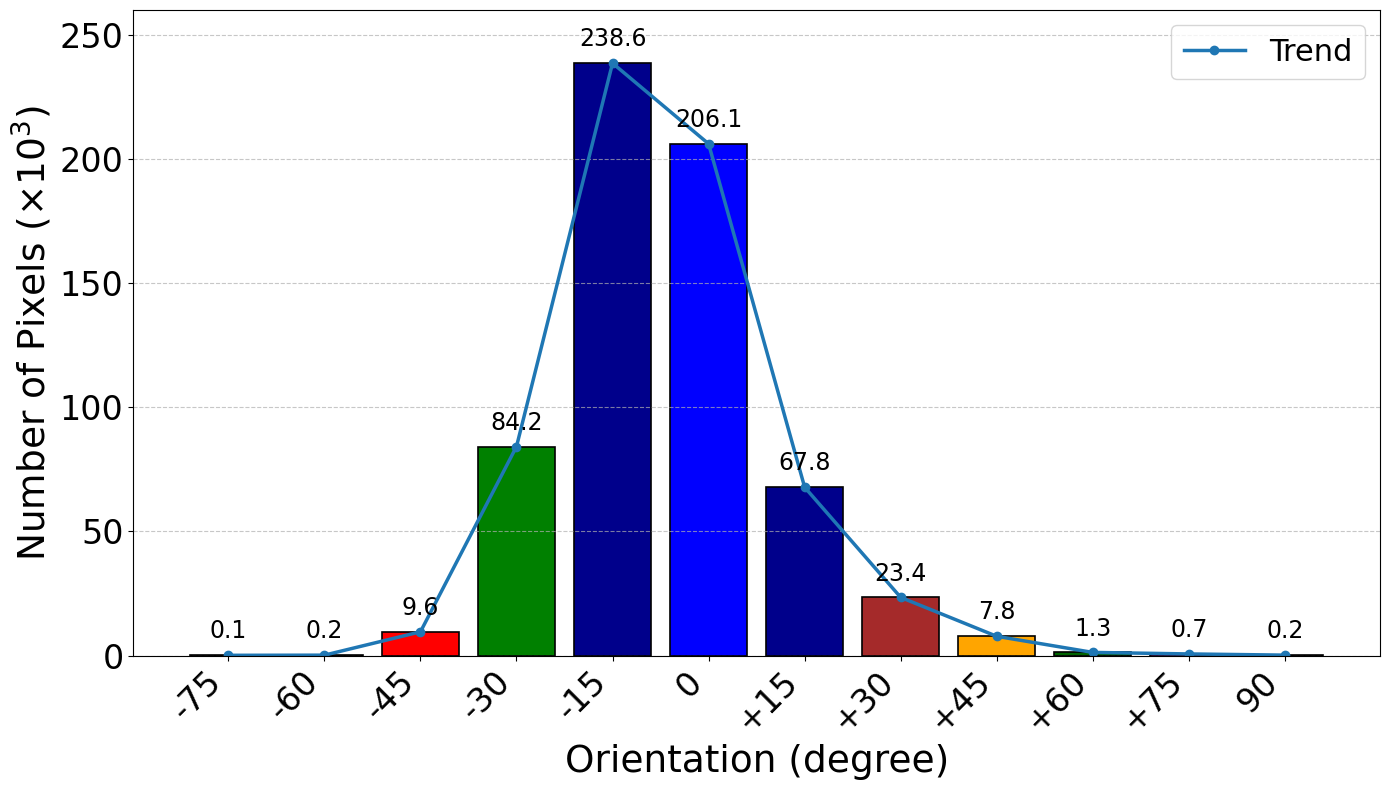

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from collections import defaultdict

# ===== Input pairs and filenames =====
angles_regular = [(-90, 0), (-75, 15), (-60, 30), (-45, 45), (-30, 60), (-15, 75), (0, 90)]
image_pairs = [
    (f'{abs(a1)}_aligned.png' if a1 > 0 else f'{a1}_aligned.png',
     f'{abs(a2)}_aligned.png' if a2 > 0 else f'{a2}_aligned.png')
    for a1, a2 in angles_regular
]

# ===== Load first image to size ROI =====
sample_image = cv2.imread(image_pairs[0][0])
if sample_image is None:
    raise FileNotFoundError(f"Sample image {image_pairs[0][0]} not found.")

roi_size = 800
h, w, _ = sample_image.shape
start_x = (w - roi_size) // 2
start_y = (h - roi_size) // 2

if start_x < 0 or start_y < 0 or start_x + roi_size > w or start_y + roi_size > h:
    raise ValueError("The ROI size is larger than the image dimensions.")

# ===== Compute BOI for each angle pair in ROI =====
BOI_values = np.zeros((len(angles_regular), roi_size, roi_size), dtype=np.float32)
diff_threshold = 5

for i, (minus_img, plus_img) in enumerate(image_pairs):
    image_plus = cv2.imread(plus_img)
    image_minus = cv2.imread(minus_img)
    if image_plus is None or image_minus is None:
        print(f"Error loading images: {plus_img} or {minus_img}")
        continue

    roi_plus = image_plus[start_y:start_y + roi_size, start_x:start_x + roi_size]
    roi_minus = image_minus[start_y:start_y + roi_size, start_x:start_x + roi_size]

    B_plus = cv2.split(roi_plus)[0].astype(np.float32) + 1
    B_minus = cv2.split(roi_minus)[0].astype(np.float32) + 1

    diff = np.abs(B_minus - B_plus)
    valid_mask = diff > diff_threshold

    BOI_blue = np.zeros_like(B_plus, dtype=np.float32)
    BOI_blue[valid_mask] = (B_minus[valid_mask] - B_plus[valid_mask]) / (B_minus[valid_mask] + B_plus[valid_mask])

    BOI_values[i] = median_filter(BOI_blue, size=3)

# ===== Pick angle index of max |BOI| per pixel and build histogram =====
max_abs_BOI_indices = np.argmax(np.abs(BOI_values), axis=0)

histogram = defaultdict(int)
for ap in angles_regular:
    histogram[(ap, True)] = 0
    histogram[(ap, False)] = 0

for i in range(roi_size):
    for j in range(roi_size):
        k = max_abs_BOI_indices[i, j]
        ap = angles_regular[k]
        is_pos = BOI_values[k, i, j] > 0
        histogram[(ap, is_pos)] += 1

# ===== Merge labels to final orientation buckets =====
merge_mapping = {
    "(-90, 0) +": "-45", "(-90, 0) -": "+45",
    "(0, 90) +": "+45", "(0, 90) -": "-45",
    "(-75, 15) +": "-30", "(-75, 15) -": "+60",
    "(-60, 30) +": "-15", "(-60, 30) -": "+75",
    "(-45, 45) +": "0",   "(-45, 45) -": "90",
    "(-30, 60) +": "+15", "(-30, 60) -": "-75",
    "(-15, 75) +": "+30", "(-15, 75) -": "-60"
}

merged_counts = {label: 0 for label in merge_mapping.values()}

for (angle_pair, is_positive), count in histogram.items():
    category = f"{angle_pair} {'+' if is_positive else '-'}"
    refined_label = merge_mapping.get(category)
    if refined_label:
        merged_counts[refined_label] += count

final_order = ["-75", "-60", "-45", "-30", "-15", "0", "+15", "+30", "+45", "+60", "+75", "90"]
ordered_labels = final_order
ordered_values = [merged_counts[label] for label in ordered_labels]

# ===== SECOND (only) CHART: colored bars, scaled to ×10^3 =====
color_mapping = {
    "-45": "red", "+45": "orange",
    "-30": "green", "+60": "darkgreen",
    "-15": "darkblue", "+75": "magenta",
    "0": "blue", "90": "purple",
    "+15": "darkblue", "-75": "yellow",
    "+30": "brown", "-60": "lime"
}
bar_colors = [color_mapping[label] for label in ordered_labels]
ordered_values_scaled = [val / 1e3 for val in ordered_values]

plt.figure(figsize=(14, 8))
x = np.arange(len(ordered_labels))

bars = plt.bar(ordered_labels, ordered_values_scaled,
               color=bar_colors, edgecolor='black', linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.plot(x, ordered_values_scaled, marker='o', linewidth=2.5, label='Trend')

# annotate
ymax = max(ordered_values_scaled) if ordered_values_scaled else 0
for bar, value in zip(bars, ordered_values_scaled):
    if value > 0:
        plt.text(bar.get_x() + bar.get_width() / 2,
                 value + (0.02 * ymax),
                 f"{value:.1f}",
                 ha='center', va='bottom', fontsize=17, color='black')

plt.xticks(ticks=x, labels=ordered_labels, fontsize=24, rotation=45, ha='right')
plt.yticks(fontsize=24)
plt.xlabel("Orientation (degree)", fontsize=27)
plt.ylabel("Number of Pixels ($\\times 10^3$)", fontsize=27)
plt.legend(fontsize=22)
plt.ylim(0, 260)  # adjust as needed

plt.tight_layout()
plt.savefig('roi_high_res_plot.png', dpi=300)
plt.show()
